# NER

- 데이터
    - CoNLL - the Conference on Natural Language Learning
    - https://github.com/Franck-Dernoncourt/NeuroNER

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re

In [30]:
ner_train_path = tf.keras.utils.get_file("ner_train.txt", "https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/refs/heads/master/neuroner/data/conll2003/en/train.txt")
ner_test_path = tf.keras.utils.get_file("ner_test.txt", "https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/refs/heads/master/neuroner/data/conll2003/en/test.txt")

### 데이터 전처리

1. (word, ner) 변환
2. 토큰화
3. sequence 처리
4. padding 처리

In [31]:
# (word, ner) tagging
def get_tagged_sentences(path):
    temp = []
    sentences = []
    
    for line in open(path, 'r', encoding='utf-8'):
        if line.startswith('-DOCSTART-') or line[0]=='\n':
            if len(temp) > 0:
                sentences.append(temp)
                temp = []
            continue
        
        word, pos, chunk, ner = line.split()
        ner = re.sub('\n', '', ner)
        word = word.lower()
        temp.append((word, ner))
        
    return sentences
        

In [32]:
train_tagged_sents = get_tagged_sentences(ner_train_path)
test_tagged_sents = get_tagged_sentences(ner_test_path)

train_tagged_sents[:5]

[[('eu', 'B-ORG'),
  ('rejects', 'O'),
  ('german', 'B-MISC'),
  ('call', 'O'),
  ('to', 'O'),
  ('boycott', 'O'),
  ('british', 'B-MISC'),
  ('lamb', 'O'),
  ('.', 'O')],
 [('peter', 'B-PER'), ('blackburn', 'I-PER')],
 [('brussels', 'B-LOC'), ('1996-08-22', 'O')],
 [('the', 'O'),
  ('european', 'B-ORG'),
  ('commission', 'I-ORG'),
  ('said', 'O'),
  ('on', 'O'),
  ('thursday', 'O'),
  ('it', 'O'),
  ('disagreed', 'O'),
  ('with', 'O'),
  ('german', 'B-MISC'),
  ('advice', 'O'),
  ('to', 'O'),
  ('consumers', 'O'),
  ('to', 'O'),
  ('shun', 'O'),
  ('british', 'B-MISC'),
  ('lamb', 'O'),
  ('until', 'O'),
  ('scientists', 'O'),
  ('determine', 'O'),
  ('whether', 'O'),
  ('mad', 'O'),
  ('cow', 'O'),
  ('disease', 'O'),
  ('can', 'O'),
  ('be', 'O'),
  ('transmitted', 'O'),
  ('to', 'O'),
  ('sheep', 'O'),
  ('.', 'O')],
 [('germany', 'B-LOC'),
  ("'s", 'O'),
  ('representative', 'O'),
  ('to', 'O'),
  ('the', 'O'),
  ('european', 'B-ORG'),
  ('union', 'I-ORG'),
  ("'s", 'O'),
  ('vete

In [33]:
def get_sents_and_labels(tagged_sentences):
    inputs, labels = [], []
    for sentence in tagged_sentences:
        tokens, ner = zip(*sentence)
        inputs.append(list(tokens))
        labels.append(list(ner))
        
    return inputs, labels

In [34]:
train_inputs, train_labels = get_sents_and_labels(train_tagged_sents)
test_inputs, test_labels =  get_sents_and_labels(test_tagged_sents)

print(len(train_inputs), len(train_labels), len(test_inputs), len(test_labels))

14041 14041 3453 3453


min-max: 1 - 113
mean: 14.501887329962253
midian: 10.0


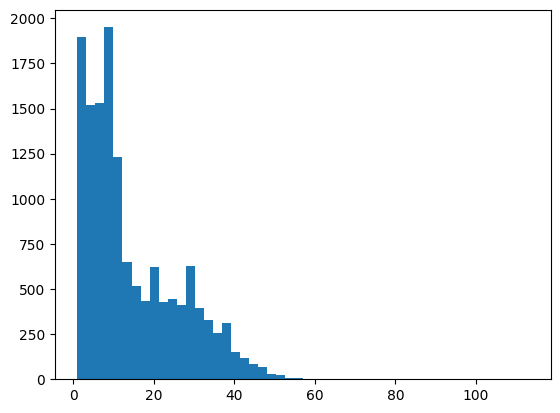

In [35]:
# 데이터 길이 확인
train_len = [len(seq) for seq in train_inputs]

print("min-max:", np.min(train_len),"-", np.max(train_len))
print("mean:", np.mean(train_len))
print("midian:", np.median(train_len))

plt.hist(train_len, bins=50)
plt.show()

In [36]:
# sequence - padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_LEN = 50
VOCAB_SIZE = 10000

entity_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
entity_tokenizer.fit_on_texts(train_inputs)

X_train = entity_tokenizer.texts_to_sequences(train_inputs)
X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding='pre', truncating='pre')

In [37]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_labels)

y_train = tag_tokenizer.texts_to_sequences(train_labels)
y_train = pad_sequences(y_train, maxlen=MAX_LEN, padding='pre', truncating='pre')

In [38]:
tag_tokenizer.index_word

{1: 'o',
 2: 'b-loc',
 3: 'b-per',
 4: 'b-org',
 5: 'i-per',
 6: 'i-org',
 7: 'b-misc',
 8: 'i-loc',
 9: 'i-misc'}

In [39]:
X_test = entity_tokenizer.texts_to_sequences(test_inputs)
X_test = pad_sequences(X_test, maxlen=MAX_LEN, padding='pre', truncating='pre')

y_test = tag_tokenizer.texts_to_sequences(test_labels)
y_test = pad_sequences(y_test, maxlen=MAX_LEN, padding='pre', truncating='pre')

### 모델 생성 및 학습

In [40]:
from tensorflow.keras import layers, models

EMBED_DIM = 100
LATENEXT_DIM = 256
TAG_SIZE = len(tag_tokenizer.word_index)

input = layers.Input(shape=(MAX_LEN,))
x = layers.Embedding(VOCAB_SIZE + 1, EMBED_DIM)(input)
lstm = layers.LSTM(LATENEXT_DIM, return_sequences=True)
x = layers.Bidirectional(lstm)(x)
output = layers.Dense(TAG_SIZE + 1, activation='softmax')(x)

model = models.Model(input, output)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 50, 100)        │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 50, 512)        │       731,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50, 10)         │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,736,366 (6.62 MB)

 Trainable params: 1,736,366 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.8486 - loss: 0.5463 - val_accuracy: 0.9526 - val_loss: 0.1999
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.9546 - loss: 0.1611 - val_accuracy: 0.9666 - val_loss: 0.1171
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 0.9765 - loss: 0.0777 - val_accuracy: 0.9759 - val_loss: 0.0857
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.9866 - loss: 0.0483 - val_accuracy: 0.9795 - val_loss: 0.0736
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 0.9911 - loss: 0.0338 - val_accuracy: 0.9812 - val_loss: 0.0692
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.9929 - loss: 0.0262 - val_accuracy: 0.9800 - val_loss: 0.0721
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 0.9941 - loss: 0.0212 - val_accuracy: 0.9817 - val_loss: 0.0706
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.9951 - loss: 0.0175 - val_accu

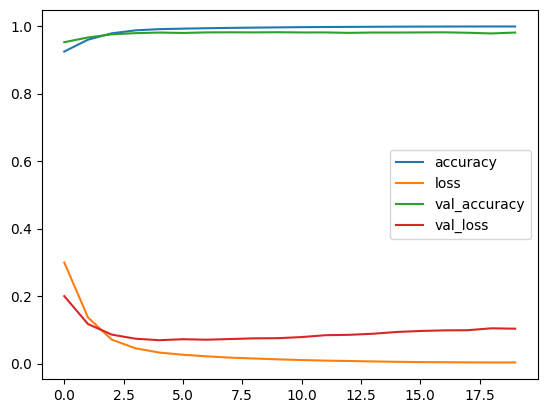

In [41]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=20,
    validation_split=0.2
)

pd.DataFrame(history.history).plot()
plt.show()

### 모델 평가

In [42]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f" test 결과 | Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.9805 - loss: 0.0957
 test 결과 | Loss: 0.0964, Accuracy: 0.9806


### NER 예측

In [43]:
sample = ["EU gave German call to take British people wow"]

sample_seq = entity_tokenizer.texts_to_sequences([sample])
sample_padded = pad_sequences(sample_seq, maxlen=MAX_LEN)

In [44]:
pred_proba = model.predict(sample_padded)

pred = np.argmax(pred_proba, axis=-1)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1]])

In [45]:
index2entity = entity_tokenizer.index_word
index2tag = tag_tokenizer.index_word

tokens = [index2entity.get(x, "?") for x in sample_padded[0]]
tags = [index2tag.get(x, "?") for x in pred[0]]

for token, tag in zip(tokens, tags):
    if token != '?':
        print(f'{token} : {tag}')

<OOV> : o
